In [1]:
from healpy import sphtfunc, visufunc, fitsfunc
from pixell import curvedsky, enmap, enplot, utils
import importlib
import numpy as np
import matplotlib.pyplot as plt
from newlens import path, load_data, rec_noise, noise_model
import ipdb
from astropy.io import fits
import os

importlib.reload(path)
importlib.reload(load_data)
importlib.reload(rec_noise)
importlib.reload(noise_model)

<module 'newlens.noise_model' from '/home/ketchup/Dropbox/cosmology/lensing/newlens/newlens/noise_model.py'>

In [2]:
nside = 1000
lmax = 2000
lmin = 2
ls = np.arange(0, lmax)
nlev_t = 27  # telmperature noise level, in uk.arclmin
nlev_p = np.sqrt(2) * 40
bealm_fwhlm = 7

noise = noise_model.noise(bealm_fwhlm, lmax, nlev_t, nlev_p)
nltt = noise.tt()
nlee = noise.ee()
nlbb = noise.bb()

In [3]:
Cl_rec_noise_TT = rec_noise.TT(lmin,lmax,bealm_fwhlm,nlev_t,nlev_p).noise()[0:lmax]
Dl_rec_noise_TT = (ls*(ls+1))*Cl_rec_noise_TT/(2*np.pi)
Cl_rec_noise_EB = rec_noise.EB(lmin,lmax,bealm_fwhlm,nlev_t,nlev_p).noise()[0:lmax]
Dl_rec_noise_EB = (ls*(ls+1))*Cl_rec_noise_TT/(2*np.pi)

In [4]:
shape, wcs = enmap.fullsky_geometry(res=20 * utils.arcmin, proj='car')

phi_lm_input = fitsfunc.read_alm('../../fullskyPhi_alm_00000.fits')
phi_lm_input = phi_lm_input.astype(np.cdouble)
Cl_phi_input = sphtfunc.alm2cl(phi_lm_input)

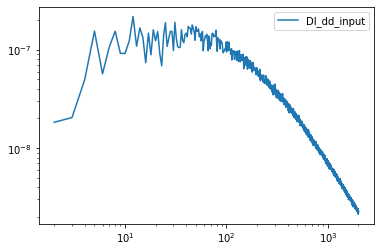

In [5]:
Cl_dd_input = (ls*(ls+1))*Cl_phi_input[0:lmax]
Dl_dd_input = (ls*(ls+1))*Cl_dd_input/(2*np.pi)
plt.plot(ls[lmin:lmax], Dl_dd_input[lmin:lmax])
plt.xscale('log')
plt.yscale('log')
plt.legend(['Dl_dd_input'])
plt.show()

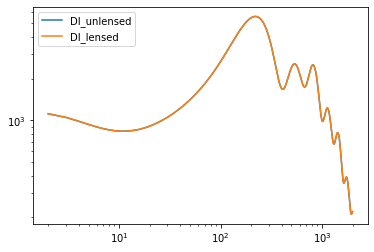

In [6]:
Cl_TT_unlsd = load_data.unlensed(lmin,lmax,'TT').spectra()[0:lmax]
Dl_TT_unlsd = (ls*(ls+1))*Cl_TT_unlsd/(2*np.pi)

lm_T_lsd = fitsfunc.read_alm('../../fullskyLensedCMB_alm_set00_00000.fits')
lm_T_lsd = lm_T_lsd.astype(np.cdouble)
Cl_TT_lsd = sphtfunc.alm2cl(lm_T_lsd)[0:lmax]
Dl_TT_lsd = (ls*(ls+1))*Cl_TT_unlsd/(2*np.pi)

plt.plot(ls[lmin:lmax], Dl_TT_unlsd[lmin:lmax])
plt.plot(ls[lmin:lmax], Dl_TT_lsd[lmin:lmax])
plt.legend(['Dl_unlensed', 'Dl_lensed'])
plt.xscale('log')
plt.yscale('log')
plt.show()

In [7]:
# now I need to generate a observed map
# Beam
def gauss_beam(ell, fwhm):
    tht_fwhm = np.deg2rad(fwhm/60)
    return np.exp(-(tht_fwhm**2.)*(ell**2.)/(16.*np.log(2.)))

lbeam=gauss_beam(ls, bealm_fwhlm)

def filter_map(lm_lensed, lbeam):
    lmmap_filtered = sphtfunc.almxfl(lm_lensed, lbeam)
    return lmmap_filtered

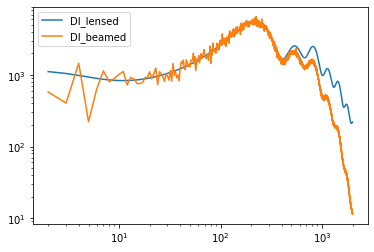

In [8]:
lm_T_beamed = filter_map(lm_T_lsd,lbeam)
Cl_TT_beamed = sphtfunc.alm2cl(lm_T_beamed)[0: lmax]
Dl_TT_beamed = (ls*(ls+1))*Cl_TT_beamed/(2*np.pi)

plt.plot(ls[lmin:lmax], Dl_TT_lsd[lmin:lmax])
plt.plot(ls[lmin:lmax], Dl_TT_beamed[lmin:lmax])
plt.legend(['Dl_lensed','Dl_beamed'])
plt.xscale('log')
plt.yscale('log')
plt.show()

In [9]:
map_T_lsd = sphtfunc.alm2map(lm_T_lsd, nside)
map_T_beamed = sphtfunc.alm2map(lm_T_beamed, nside)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [10]:
# Noise
ell = np.arange(0, lmax+1)
noise_uk_arcmin = nlev_t

Cl_noise_TT = (noise_uk_arcmin*np.pi/180./60.)**2*np.ones(ell.shape)

map_noise_T = sphtfunc.synfast(Cl_noise_TT, nside)

map_T_obs_sim = map_T_beamed + map_noise_T
lm_T_obs_sim = sphtfunc.map2alm(map_T_obs_sim)

if os.path.exists('../lm_obs.fits'):
    os.remove('../lm_obs.fits')
fitsfunc.write_alm('../lm_obs.fits', lm_T_obs_sim)

/home/ketchup/tools/anaconda3/lib/python3.7/site-packages/healpy/sphtfunc.py:400: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  category=FutureChangeWarning,


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


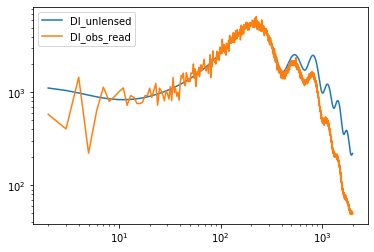

In [11]:
lm_T_obs_read = fitsfunc.read_alm('../lm_obs.fits')
Cl_TT_obs_read = sphtfunc.alm2cl(lm_T_obs_read)[0:lmax]
Dl_TT_obs_read = (ls*(ls+1)*Cl_TT_obs_read)/(2*np.pi)

plt.plot(ls[lmin:lmax], Dl_TT_unlsd[lmin:lmax])
plt.plot(ls[lmin:lmax], Dl_TT_obs_read[lmin:lmax])
plt.legend(['Dl_unlensed','Dl_obs_read'])
plt.xscale('log')
plt.yscale('log')
plt.show()

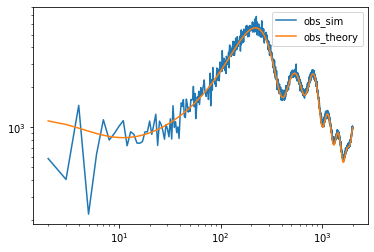

In [12]:
lm_T_obs = filter_map(lm_T_obs_read, 1/lbeam) # divided by bl
Cl_TT_obs = sphtfunc.alm2cl(lm_T_obs)[0:lmax]
Dl_TT_obs = (ls*(ls+1))*Cl_TT_obs/(2*np.pi)

Cl_TT_theory_noise = noise_model.noise(bealm_fwhlm,lmax,nlev_t,nlev_p).tt()[0:lmax]
Dl_TT_theory_noise = (ls*(ls+1))*Cl_TT_theory_noise/(2*np.pi)
plt.plot(ls[lmin:lmax], Dl_TT_obs[lmin:lmax])
plt.plot(ls[lmin:lmax], (Dl_TT_unlsd + Dl_TT_theory_noise)[lmin:lmax])
plt.legend(['obs_sim','obs_theory'])
plt.xscale('log')
plt.yscale('log')

In [13]:
# reconstruction
class rec_TT:
    """ using TT estimator to reconstruct phi_lm and phi_cl using healpy """

    def __init__(self, *args):
        """input spectra"""
        self.lmax = args[0]
        self.nside = args[1]
        self.Cl_unlsd = args[2][0:self.lmax]

        self.lm_obs = args[3]
        self.Cl_obs = args[4][0:self.lmax]
        self.norm = args[5][0:self.lmax]

    def factor(self):
        ell = np.arange(0, self.lmax)
        return ell * (ell + 1)
    
    def weight1(self):
        ell = np.arange(0, self.lmax)

        lm_1 = sphtfunc.almxfl(self.lm_obs, (-ell*(ell+1)/self.Cl_obs))
        map1 = sphtfunc.alm2map(lm_1, self.nside)

        lm_2 = sphtfunc.almxfl(self.lm_obs, self.Cl_unlsd/self.Cl_obs)
        map2 = sphtfunc.alm2map(lm_2, self.nside)

        lm_ret = sphtfunc.map2alm(map1*map2, lmax=self.lmax)
        return lm_ret

    def weight2(self):
        ell = np.arange(0, self.lmax)

        lm_1 = sphtfunc.almxfl(self.lm_obs, 1/self.Cl_obs)
        map1 = sphtfunc.alm2map(lm_1, self.nside)

        lm_2 = sphtfunc.almxfl(self.lm_obs, (ell*(ell+1)*self.Cl_unlsd/self.Cl_obs))
        map2 = sphtfunc.alm2map(lm_2, self.nside)

        lm_ret = sphtfunc.map2alm(map1*map2, lmax=self.lmax)
        return lm_ret
    
    def weight3(self):
        ell = np.arange(0, self.lmax)

        lm_1 = sphtfunc.almxfl(self.lm_obs, 1/self.Cl_obs)
        map1 = sphtfunc.alm2map(lm_1, self.nside)

        lm_2 = sphtfunc.almxfl(self.lm_obs, self.Cl_unlsd/self.Cl_obs)
        map2 = sphtfunc.alm2map(lm_2, self.nside)

        lm_ret = sphtfunc.almxfl(
            sphtfunc.map2alm(map1 * map2, lmax=self.lmax), self.factor())
        return lm_ret


    def lm_d(self):
        ell = np.arange(0, self.lmax)
        lm_d = sphtfunc.almxfl(self.weight1()+self.weight2()+self.weight3(), 1/2*self.norm[ell]/(np.sqrt(self.factor())))
        return lm_d

    def var_dd(self):
        ell = np.arange(0, self.lmax)
        return sphtfunc.alm2cl(self.lm_d())


In [14]:
Cl_rec_noise_TT = rec_noise.TT(lmin,lmax,bealm_fwhlm,nlev_t,nlev_p).noise()[0:lmax]
Dl_rec_noise_TT = (ls*(ls+1))*Cl_rec_noise_TT/(2*np.pi)
Cl_rec_noise_EB = rec_noise.EB(lmin,lmax,bealm_fwhlm,nlev_t,nlev_p).noise()[0:lmax]
Dl_rec_noise_EB = (ls*(ls+1))*Cl_rec_noise_TT/(2*np.pi)

In [15]:
norm_TT = Cl_rec_noise_TT
Rec_TT = rec_TT(lmax, nside, Cl_TT_unlsd, lm_T_obs, Cl_TT_obs, norm_TT)
var_dd_TT = Rec_TT.var_dd()[0:lmax]
Cl_dd_rec_TT = var_dd_TT - Cl_rec_noise_TT
Dl_dd_rec_TT = (ls*(ls+1))*Cl_dd_rec_TT/(2*np.pi)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


/home/ketchup/tools/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


/home/ketchup/tools/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


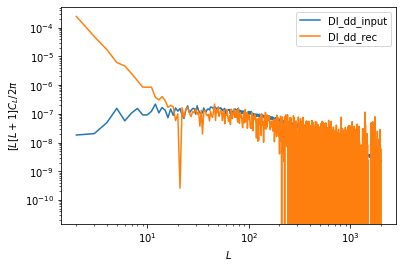

In [16]:
plt.plot(ls[lmin:lmax], Dl_dd_input[lmin:lmax])
plt.plot(ls[lmin:lmax], Dl_dd_rec_TT[lmin:lmax])
#plt.plot(ls[lmin:lmax], Dl_rec_noise_TT[lmin:lmax])
plt.legend(['Dl_dd_input','Dl_dd_rec'])
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$L$')
plt.ylabel(r'$[L[L+1] C_L / 2\pi$')
#plt.savefig('./figure/Dl_dd_rec.png')
plt.show()

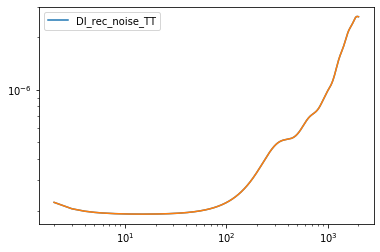

In [17]:
plt.plot(ls[lmin:lmax], Dl_rec_noise_TT[lmin:lmax])
plt.plot(ls[lmin:lmax], Dl_rec_noise_EB[lmin:lmax])
plt.legend(['Dl_rec_noise_TT'])
plt.xscale('log')
plt.yscale('log')
plt.savefig('../figure/Dl_rec_noise_TT.png')
plt.show()